In [1]:
from tournament.agents.constant import AllC, AllD
from tournament.agents.pavlov import Pavlov
from tournament.agents.q_learning.dqn import DeepQLearner
from tournament.agents.tft import TFTT, GenerousTFT, TitForTat
from tournament.environments.single import SingleRuleBasedAgentEnvironment
from tournament.environments.multiple import MultipleRuleBasedAgentEnvironment
from tournament.agents.agents import AGENTS
from tournament.agents.axelrod_first import (
    Davis,
    Downing,
    Feld,
    Grofman,
    Grudger,
    Joss,
    Nydegger,
    Shubik,
    SteinAndRapoport,
    TidemanAndChieruzzi,
    Tullock,
)
from tournament.agents.tft import (
    TFTT,
    TTFT,
    GenerousTFT,
    GradualTFT,
    OmegaTFT,
    TitForTat,
)
from tournament.tournament import RoundRobinTournament

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# env = SingleRuleBasedAgentEnvironment(TitForTat)
env = MultipleRuleBasedAgentEnvironment([
    TitForTat,
    # AllC,
    # TFTT,
    # TTFT,
    # GenerousTFT,
    # GradualTFT,
    OmegaTFT,
])

In [3]:
class QNetwork(nn.Module):
    def __init__(self, lookback):
        super().__init__()

        # self.elu = nn.ELU()

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(2 * lookback, 32)
        self.layer2 = nn.Linear(32, 32)
        # self.layer3 = nn.Linear(32, 32)
        self.layer4 = nn.Linear(32, 2)

        nn.init.kaiming_uniform_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        # nn.init.kaiming_uniform_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.layer4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.unsqueeze(dim=0)
        x = self.flatten(x)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        # x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))

        return x

class QLearningTest(DeepQLearner):
    lookback = 8
    epsilon = 0.15

    def __init__(self):
        super().__init__()

        self._learning_rate = 0.15
        self._q_network = QNetwork(self.lookback)


agent = QLearningTest()

In [4]:
env.train(
    trainee=agent,
    continuation_probability=1,
    limit=250,
    noise=0,
    repetitions=10,
    epochs=15,
)

[15:36:59] Commencement of training.
[15:36:59] Training against TitForTat
[15:37:05] Training against OmegaTFT
[15:37:08] Completed epoch 1: 9.221894542261772
[15:37:08] Training against TitForTat
[15:37:12] Training against OmegaTFT
[15:37:16] Completed epoch 2: 9.395747271130887
[15:37:16] Training against TitForTat
[15:37:20] Training against OmegaTFT
[15:37:23] Completed epoch 3: 9.445898180753924
[15:37:23] Training against TitForTat
[15:37:27] Training against OmegaTFT
[15:37:31] Completed epoch 4: 9.473873635565443
[15:37:31] Training against TitForTat
[15:37:35] Training against OmegaTFT
[15:37:39] Completed epoch 5: 9.492938908452354
[15:37:39] Training against OmegaTFT
[15:37:43] Training against TitForTat
[15:37:47] Completed epoch 6: 9.361615757043628
[15:37:47] Training against OmegaTFT
[15:37:51] Training against TitForTat
[15:37:56] Completed epoch 7: 9.38309922032311
[15:37:56] Training against OmegaTFT
[15:38:00] Training against TitForTat
[15:38:04] Completed epoch 8

In [5]:
print(agent._q_network)
print(env.counts)

s = sum(env.counts.values())

print({a: env.counts[a] / s for a in env.counts})

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=2, bias=True)
)
{<Action.COOPERATE: 0>: 67499, <Action.DEFECT: 1>: 7501}
{<Action.COOPERATE: 0>: 0.8999866666666667, <Action.DEFECT: 1>: 0.10001333333333333}


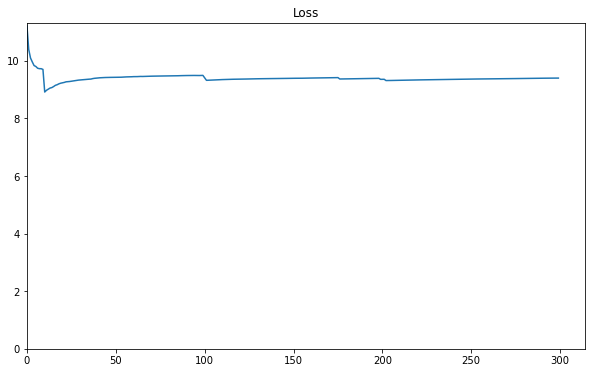

In [6]:
plt.title("Loss")
plt.plot(env.metric_history)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

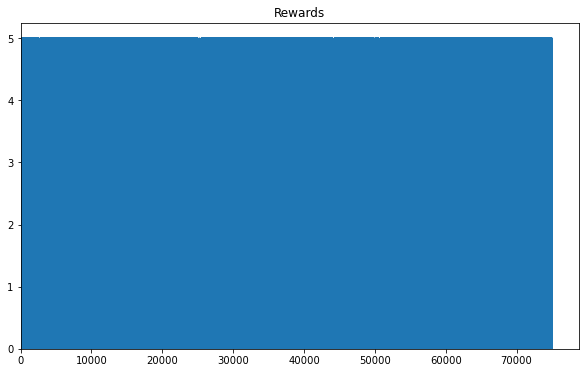

In [7]:
plt.title("Rewards")
plt.plot(env.rewards)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

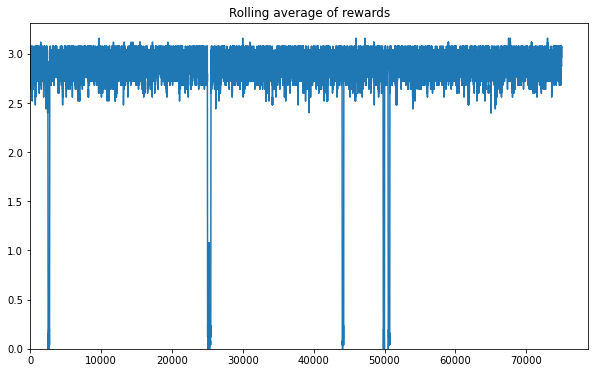

In [8]:
N = 25

plt.title("Rolling average of rewards")
plt.plot(np.convolve(env.rewards, np.ones(N), mode='valid') / N)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

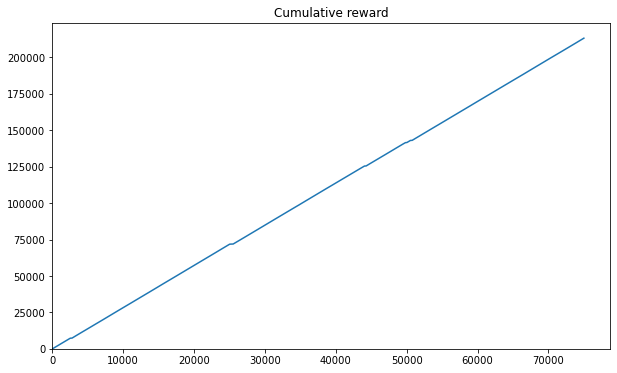

In [9]:
plt.title("Cumulative reward")
plt.plot(np.cumsum(env.rewards))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

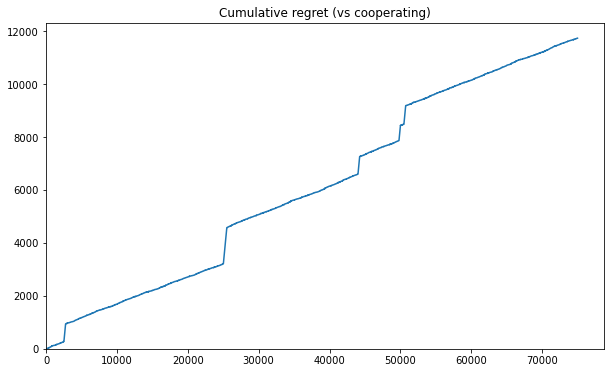

In [10]:
plt.title("Cumulative regret (vs cooperating)")
plt.plot(np.cumsum(3 - np.array(env.rewards)))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

In [11]:
# torch.save(agent._q_network.state_dict(), "model.pt")

In [12]:
agent._q_network.eval()

QNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=2, bias=True)
)

In [13]:
tournament = RoundRobinTournament(AGENTS, [agent])

scores, times = tournament.play(
    continuation_probability=0.99654, repetitions=20, jobs=12
)

results = [
    (agent, round(sum(scores[agent]) / len(scores[agent])), sum(times[agent]))
    for agent in scores
]
results.sort(key=lambda x: x[1], reverse=True)

for c, score, time in results:
    print(f"{c.__name__:<30} {score:<20} {time:<20}")


100%|██████████| 961/961 [01:00<00:00, 15.88matches/s] 

GraaskampAndKatzen        819                  5.799374000000002   
SteinAndRapoport               800                  19.047557000000005  
TidemanAndChieruzzi            797                  6.9146009999999976  
TTFT                           792                  5.341500999999999   
Shubik                         785                  5.351217000000001   
Davis                          781                  9.659578            
Borufsen                       778                  6.223267000000001   
OmegaTFT                       777                  6.228162999999999   
TFTT                           777                  5.535778000000002   
Weiner                 777                  14.49709            
SecondByBlackK83R              773                  7.603985            
Champion                       764                  29.46392499999999   
White              762                  6.062139000000002   
TidemanAndChieruzzi2    759                  6.862776000000001   
GradualTFT